In [132]:
import json
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tqdm.pandas()

#device = torch.device('cpu')
device = torch.device('cuda')

In [133]:
bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

In [134]:
services = {}
current_service = ""
with open('data.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        if line:
            if line.startswith("!"):
                current_service = line[1:]
                services[current_service] = []
            else:
                services[current_service].append(line)
print(len(services), " services")
with open("data.json", "w", encoding='utf-8') as outfile:
    json.dump(services, outfile, ensure_ascii=False, indent=4)

58  services


In [135]:
idx = iter(list(range(len(services.keys()))))
label_key_mapping = {key: next(idx) for key in services.keys()}
idx = iter(list(range(len(services.keys()))))
key_label_mapping = {next(idx): key for key in services.keys()}

# test
key_label_mapping[42], label_key_mapping['Детские пособия'] 

('Детские пособия', 42)

In [136]:
data = {}
idx = 0
for service in services.keys():
    for text in services[service]:
        data[idx] = {'text': text, 'target': [1 if label_key_mapping[service] == lable else 0 for lable in range(len(services))]}
        idx+=1
df = pd.DataFrame.from_dict(data, orient='index')
df = df.sample(frac=1).reset_index(drop=True)
amount = len(df)
test_amount = val_amount = int(amount * 0.2)
test_amount, val_amount

(91, 91)

In [137]:
df

,text,target
0,Подробное описание сроков хранения выписки о д...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Условия и стоимость инвестиционных услуг.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"Опыт и рекомендации от налогоплательщиков, пол...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Что включает в себя страхование от мошенничества?,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Каким образом можно получить сопровождение при...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
451,Преимущества и отзывы о защите телефона.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
452,Преимущества и отзывы о материнском капитале.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
453,Преимущества и ограничения страхования от моше...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
454,Что представляет собой инвестиционное страхова...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [138]:
test_df = df[:test_amount]
test_df = test_df.reset_index(drop=True)
train_df = df[test_amount:-val_amount]
train_df = train_df.reset_index(drop=True)
val_df = df[val_amount:]
val_df = val_df.reset_index(drop=True)

In [139]:
train_text = train_df['text'].astype('str')
train_labels = train_df['target']
train_labels = torch.tensor(train_labels).to(torch.float32)
val_text = val_df['text'].astype('str')
val_labels = val_df['target']
val_labels = torch.tensor(val_labels).to(torch.float32)
test_text = test_df['text'].astype('str')
test_labels = test_df['target']
test_labels = torch.tensor(test_labels).to(torch.float32)

In [140]:
test_labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

<Axes: >

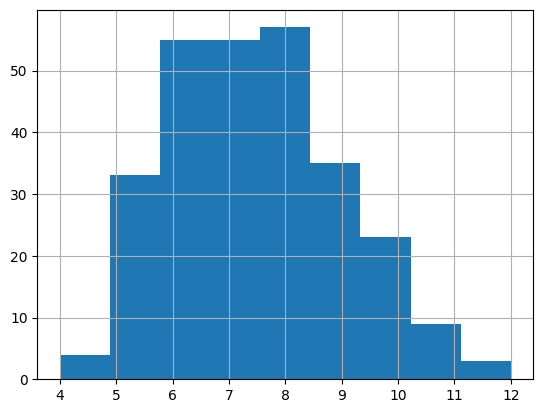

In [141]:
seq_len = [len(str(i).split()) for i in train_text]
pd.Series(seq_len).hist(bins = 9)

In [160]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.values,
    max_length = 50,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.values,
    max_length = 50,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.values,
    max_length = 50,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)
batch_size = 128


train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

/tmp/ipykernel_317617/2564822780.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_labels)
/tmp/ipykernel_317617/2564822780.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_y = torch.tensor(val_labels)
/tmp/ipykernel_317617/2564822780.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y = torch.tensor(test_labels)


In [161]:
train_labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [162]:
tokens_train

{'input_ids': [[101, 72504, 9976, 851, 22606, 38561, 84264, 612, 35869, 4179, 32218, 132, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 5405, 69708, 48428, 13259, 869, 65986, 1455, 98163, 869, 861, 2881, 91499, 1455, 166, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 78707, 3426, 851, 38132, 1641, 92058, 26077, 132, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 36947, 851, 30129, 1641, 25693, 128, 25396, 23258, 2784, 63932, 7214, 132, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 67049, 11520, 851, 51507, 845, 9881, 104793, 26829, 132, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 36947, 851, 30129, 1641,

In [163]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,len(services))
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [164]:
model = BERT_Arch(bert)

model = model.to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(),
               lr= 1e-3)

/home/arzym/.local/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [165]:
train_labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [166]:
"""
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight="balanced",
                                        classes=np.unique(train_labels), 
                                        y=train_labels
                                    )
                                    

print(class_weights)
#[0.8086199  1.31005794]

weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
"""
cross_entropy = nn.CrossEntropyLoss()
epochs = 64


In [167]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds

In [168]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    return avg_loss, total_preds

In [175]:
best_valid_loss = float('inf')

#train_losses = []
#valid_losses = []

epochs = 16

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss, _ = train()
    valid_loss, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 16


100%|██████████| 3/3 [00:00<00:00,  5.50it/s]



Training loss: 0.193
Validation loss: 0.390

 Epoch2 / 16


100%|██████████| 3/3 [00:00<00:00,  5.50it/s]



Training loss: 0.215
Validation loss: 0.386

 Epoch3 / 16


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]



Training loss: 0.208
Validation loss: 0.400

 Epoch4 / 16


100%|██████████| 3/3 [00:00<00:00,  5.51it/s]



Training loss: 0.220
Validation loss: 0.401

 Epoch5 / 16


100%|██████████| 3/3 [00:00<00:00,  5.58it/s]



Training loss: 0.200
Validation loss: 0.397

 Epoch6 / 16


100%|██████████| 3/3 [00:00<00:00,  5.53it/s]



Training loss: 0.199
Validation loss: 0.385

 Epoch7 / 16


100%|██████████| 3/3 [00:00<00:00,  5.50it/s]



Training loss: 0.175
Validation loss: 0.368

 Epoch8 / 16


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]



Training loss: 0.163
Validation loss: 0.372

 Epoch9 / 16


100%|██████████| 3/3 [00:00<00:00,  5.53it/s]



Training loss: 0.204
Validation loss: 0.379

 Epoch10 / 16


100%|██████████| 3/3 [00:00<00:00,  5.42it/s]



Training loss: 0.172
Validation loss: 0.378

 Epoch11 / 16


100%|██████████| 3/3 [00:00<00:00,  5.54it/s]



Training loss: 0.154
Validation loss: 0.371

 Epoch12 / 16


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]



Training loss: 0.122
Validation loss: 0.369

 Epoch13 / 16


100%|██████████| 3/3 [00:00<00:00,  5.56it/s]



Training loss: 0.177
Validation loss: 0.363

 Epoch14 / 16


100%|██████████| 3/3 [00:00<00:00,  5.53it/s]



Training loss: 0.158
Validation loss: 0.362

 Epoch15 / 16


100%|██████████| 3/3 [00:00<00:00,  5.53it/s]



Training loss: 0.189
Validation loss: 0.362

 Epoch16 / 16


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


Training loss: 0.185
Validation loss: 0.374


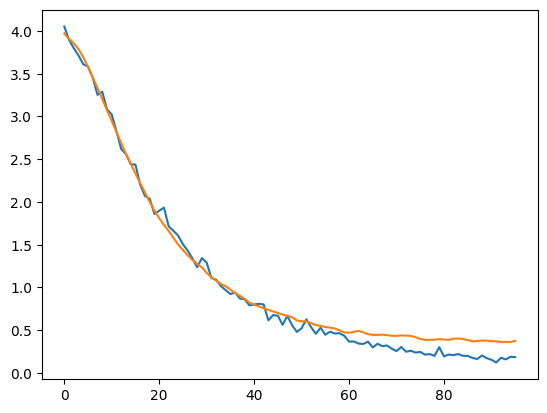

In [176]:
from matplotlib import pyplot as plt

plt.plot(train_losses)
plt.plot(valid_losses)

In [181]:
import gc
gc.collect()
torch.cuda.empty_cache()

list_seq = np.array_split(test_seq, 50)
list_mask = np.array_split(test_mask, 50)


predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().numpy())




flat_preds = [item for sublist in predictions for item in sublist]
flat_preds = (flat_preds - np.min(flat_preds)) / (np.max(flat_preds) - np.min(flat_preds))
for i in range(len(test_df)):
    test_df.iloc[0]['confidence'] = flat_preds[i]

/tmp/ipykernel_317617/1582943851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.iloc[0]['confidence'] = flat_preds[i]


In [200]:
test_df['pred'] = test_df['confidence'].apply(lambda x: 1 if x>0.92 else 0)



In [224]:
flat_preds[0]

array([0.7868327 , 0.9151046 , 0.85918254, 0.9094134 , 0.8804799 ,
       0.84047973, 0.96408373, 0.9544228 , 0.88597655, 0.77532244,
       0.64438164, 0.71864635, 0.56613076, 0.6136267 , 0.60675794,
       0.68239695, 0.79011565, 0.7024209 , 0.78851545, 0.6316485 ,
       0.6818955 , 0.7341915 , 0.7374809 , 0.6808957 , 0.77104205,
       0.680764  , 0.6980273 , 0.67822057, 0.638573  , 0.70045924,
       0.63149667, 0.63229316, 0.6135235 , 0.66461843, 0.71816945,
       0.64473087, 0.69514674, 0.74184954, 0.7756425 , 0.71500856,
       0.66457   , 0.7271108 , 0.73867476, 0.7983592 , 0.88849443,
       0.63042486, 0.7695793 , 0.6495458 , 0.6819681 , 0.79787844,
       0.63975173, 0.6292377 , 0.8515673 , 0.7825434 , 0.60346603,
       0.64685524, 0.62270975, 0.5990713 ], dtype=float32)

In [226]:
key_label_mapping.to_csv("key_label_mapping.csv")

AttributeError: 'dict' object has no attribute 'to_csv'

In [228]:
print(label_key_mapping )

{'Справка о наличии счетов': 0, 'Справка о доступном остатке по счету': 1, 'Справка о доступном остатке по карте': 2, 'Справка об оборотах по счетам и остаткам': 3, 'Справка об оборотах по картам и остатках': 4, 'Справка об уплаченных процентах': 5, 'Справка о закрытии кредита': 6, 'Справка о наличии ссудной задолженности': 7, 'Справка об общей задолженности': 8, 'Сведения для госслужащих': 9, 'Налоговый вычет по ИИС': 10, 'Антиклещ': 11, 'ОСАГО с кешбэком 10%': 12, 'КАСКО Лайт': 13, 'Спортзащита': 14, 'Страхование жилья': 15, 'Страхование от критических заболеваний': 16, 'Страхование от мошенничества': 17, 'Страхование кредитной карты': 18, 'Защити детей': 19, 'Детское страхование от критических заболеваний': 20, 'Кадровый советник': 21, 'Защити жилье': 22, 'Юридическая помощь': 23, 'Налогия': 24, 'Спроси доктора': 25, 'Мужское и женское здоровье': 26, 'Спутник здоровья': 27, 'Мультисервис': 28, 'Защита телефона': 29, 'Новое поколение': 30, 'Мое здоровье': 31, 'Накопительное страхован